In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import importlib
import lumped_parameter_model
import utils 
import stats
importlib.reload(lumped_parameter_model)
importlib.reload(utils)
importlib.reload(stats)
from lumped_parameter_model import *
from stats import *
from lumped_parameter_model import *
from utils import *
from scipy import optimize
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb

### Features for model
- Precip
- Recharge
- Rolling average head
- Rolling avg precip
- Previous discharge ? 
- Effective K (use the K vs. head curve and estimate K)

In [ ]:
#individual CSVs
dis = pd.read_csv('BSdischarge2017_2020.csv',header = 3)[['Date / Time', 
       '55A0000406 Adjusted Level (ft.)', 
      '55A0000406 Discharge (m^3/sec)']].dropna()
dis = dis.rename({'Date / Time' : "date", 
       '55A0000406 Adjusted Level (ft.)' : "water level[ft]", 
      '55A0000406 Discharge (m^3/sec)' : 'Q [m3/s]'}, axis = 1)
dis.to_csv("discharge_2017_2020.csv", index = False )
p1 = pd.read_csv('../precipitation/precip_2017_2021.csv')
p = p1[['DATE', 'DailyPrecipitation']].rename({"DailyPrecipitation" : "PRCP"}, axis = 1)
p['PRCP'] = p['PRCP'].replace('T', 0).fillna(0).astype(float)
p = convert_df_to_date_time(p, 'DATE')
p.index = p['DATE']

p = p.groupby(p.index.date).max()
p.to_csv("../precipitation/precip_clean_2017_2021.csv", index = False)
dis = convert_df_to_date_time(pd.read_csv('discharge_2017_2020.csv'), 'date').rename({"date" : "DATE"}, axis = 1)
precip = convert_df_to_date_time(pd.read_csv('../precipitation/precip_clean_2017_2021.csv'), "DATE")
rech = convert_df_to_date_time(pd.read_csv('2017_2021_simulated_recharge_hourly.csv'), 'DATE')
h = convert_df_to_date_time(pd.read_csv('../gw_level/gw_2018_2021_clean.csv'), 'date').rename({"date" : "DATE"}, axis = 1)
daily_Q = convert_hourly_to_daily(dis, 'DATE')
daily_r = convert_hourly_to_daily(rech, 'DATE')
daily_Q.index = daily_Q['DATE']
daily_r.index = daily_r['DATE']
precip.index = precip['DATE'].dt.date
h.index = h['DATE']
daily_Q = daily_Q.drop("DATE", axis = 1)
daily_r = daily_r.drop("DATE", axis = 1)
precip = precip.drop("DATE", axis = 1)
h = h.drop("DATE", axis = 1)
df = daily_Q.join(h).join(precip).join(daily_r)
df.to_csv('ml_daily_raw_data.csv')
hourly_p = convert_daily_to_hourly(precip[['DATE', 'PRCP']], 'DATE', interp_method= 'uniform')
hourly_h = convert_daily_to_hourly(h[['DATE', 'gw_elev[ft]']], 'DATE')
#full dataset
df = pd.merge(pd.merge(pd.merge(hourly_h, hourly_p, how = 'outer', on = 'DATE'),rech, how = 'right', on = 'DATE'), dis, how = 'left', on = 'DATE')
df.to_csv('ml_raw_hourly_data.csv', index = False)

C:\Users\huan1428\AppData\Local\Temp\ipykernel_4104\2145101116.py:1: DtypeWarning: Columns (3,4,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  dis = pd.read_csv('BSdischarge2017_2020.csv',header = 3)[['Date / Time',


In [2]:
df = pd.read_csv('ml_daily_raw_data.csv')

In [3]:
df = df[df['Q [m3/s]'].isna() == False] #filter out empty Q values
df['gw_elev[m]'] = df['gw_elev[ft]'] * .3048
df['Q [m3/d]']  = df['Q [m3/s]'] * 86400


In [4]:
df = convert_df_to_date_time(df, "DATE")
df.index = df["DATE"]
df =df.drop("DATE", axis = 1)

In [58]:
#time series related features
df['month'] = df.index.month
df['month'] = df['month'].shift(1)
df['is_growing_season'] = df['month'].isin([6,7,8,9]).astype(int).shift(1)
df['RCH[m/day]'] = df['RCH[m/day]'].shift(1)

In [59]:
#rolling average Q
df['Q 1d avg'] =  df['Q [m3/d]'].shift(1).rolling(window ='1D').mean()
df['Q 3d avg'] = df['Q [m3/d]'].shift(1).rolling(window ='3D').mean()
df['Q 7d avg']= df['Q [m3/d]'].shift(1).rolling(window ='7D').mean()
# df['Q 12h avg'] = df['Q [m3/s]'].shift(1).rolling(window ='12h').mean()

In [60]:
#precip
df['precip cum 1d [in]'] = df['PRCP'].shift(1).rolling(window = '1D').sum()
df['precip cum 3d [in]'] = df['PRCP'].shift(1).rolling(window = '3D').sum()
df['precip cum 7d [in]'] = df['PRCP'].shift(1).rolling(window = '7D').sum()


In [61]:
#head 
df['head 1d avg'] = df['gw_elev[m]'].shift(1).rolling(window = '1D').mean()
df['head 3d avg'] = df['gw_elev[m]'].shift(1).rolling(window = '3D').mean()
df['head 7d avg'] = df['gw_elev[m]'].shift(1).rolling(window = '7D').mean()

## Exploratory data analysis

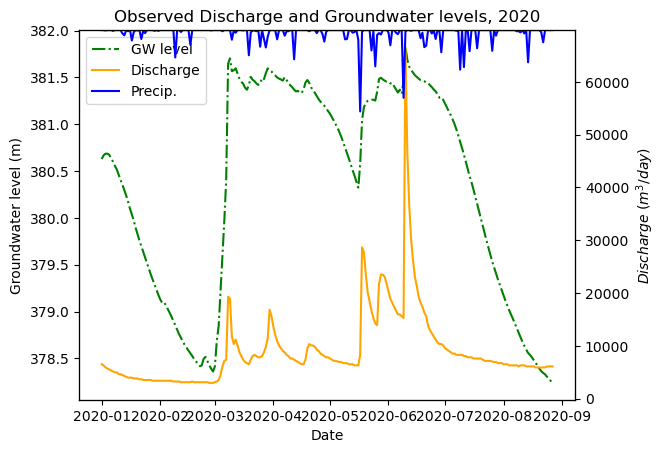

In [9]:
year = 2020
temp = df[df.index.year == year]
fig, ax = plt.subplots()
twinax = ax.twinx()
twin2 = ax.twinx()
sns.lineplot(x = temp.index, y = temp['gw_elev[m]'], label = 'GW level', ax= ax, linestyle = '-.', color = 'green', legend = False)
sns.lineplot(x = temp.index, y = temp['Q [m3/d]'], label = 'Discharge', ax = twinax, color = 'orange', legend = False)
sns.lineplot(x = temp.index, y = temp['PRCP'], label = 'Precip.', ax = twin2, color = 'blue', legend = False)
twin2.set_ylim(0,10)
twin2.invert_yaxis()
twin2.yaxis.set_ticks([])                 # Remove ticks
twin2.yaxis.set_ticklabels([])            # Remove tick labels
twin2.set_ylabel('') 
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = twinax.get_legend_handles_labels()
handles3, labels3 = twin2.get_legend_handles_labels()

# Combine legends and place them properly
ax.legend(handles1 + handles2 + handles3, labels1 + labels2 + labels3,  loc="upper left")
ax.set_xlabel("Date")
ax.set_ylabel("Groundwater level (m)")
twinax.set_ylabel(r'$Discharge\ (m^3/day)$') 
plt.title(f"Observed Discharge and Groundwater levels, {year}")
plt.savefig(f"figs/h_Q_precip_{year}.png", bbox_inches = "tight", transparent = True)

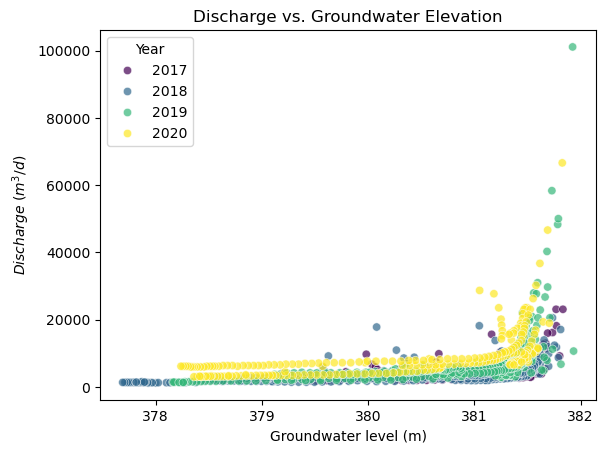

In [10]:
sns.scatterplot(x = df['gw_elev[m]'], y = df['Q [m3/d]'], hue = df.index.year, palette = 'viridis', alpha = 0.7)
plt.ylabel(r'$Discharge\ (m^3/d)$')
# plt.yscale("log")
plt.xlabel("Groundwater level (m)")
plt.legend(title = 'Year')
plt.title("Discharge vs. Groundwater Elevation")
plt.savefig('figs/Q_vs_h.png', bbox_inches = 'tight', transparent = True)

<Axes: xlabel='month', ylabel='Q [m3/d]'>

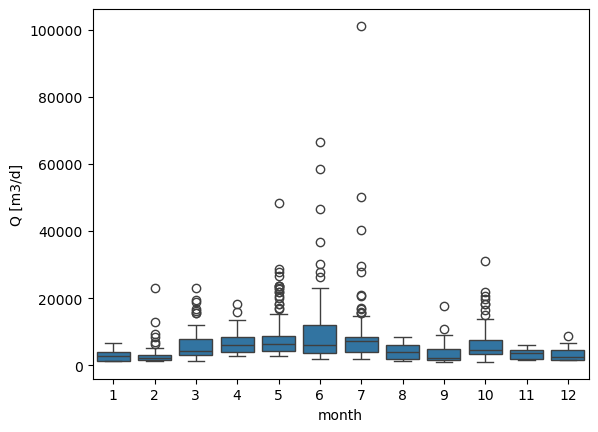

In [11]:
sns.boxplot(data = df, x= 'month', y = 'Q [m3/d]')

<Axes: >

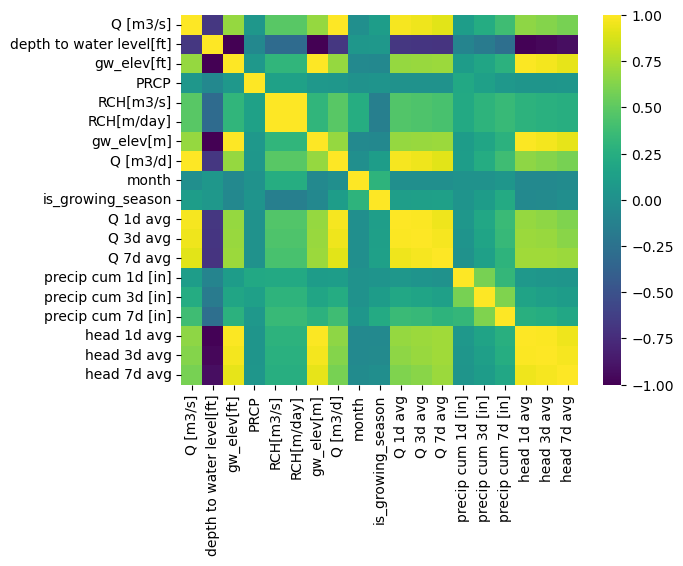

In [12]:
sns.heatmap(df.corr("spearman"), cmap = 'viridis')

Q [m3/d]
RCH[m/day]            0.483704
Q 1d avg              0.973943
Q 3d avg              0.951189
Q 7d avg              0.911527
precip cum 7d [in]    0.377297
head 1d avg           0.659258
head 3d avg           0.632098
head 7d avg           0.590431
Q [m3/d]              1.000000
gw_elev[m]            0.682837
Name: Q [m3/d], dtype: float64
gw_elev[m]
RCH[m/day]     0.311691
Q 1d avg       0.684938
Q 3d avg       0.690616
Q 7d avg       0.695486
head 1d avg    0.986105
head 3d avg    0.966465
head 7d avg    0.922941
Q [m3/d]       0.682837
gw_elev[m]     1.000000
Name: gw_elev[m], dtype: float64


<Axes: >

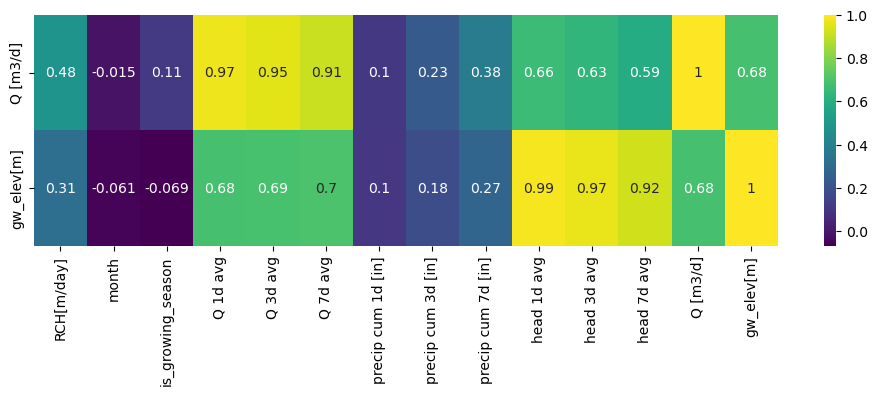

In [73]:
corr_df = df[['RCH[m/day]', 'month', 'is_growing_season','Q 1d avg', 
       'Q 3d avg', 'Q 7d avg', 'precip cum 1d [in]',
       'precip cum 3d [in]', 'precip cum 7d [in]', 
       'head 1d avg',
       'head 3d avg', 'head 7d avg','Q [m3/d]', 'gw_elev[m]']].corr('spearman').loc[['Q [m3/d]', 'gw_elev[m]']]
for i in corr_df.index:
    print(i)
    print(corr_df.loc[i][abs(corr_df.loc[i]) > 0.3])
fig, ax = plt.subplots(figsize = (12,3))
sns.heatmap(corr_df, cmap = 'viridis', annot = True)


In [207]:
y = 'Q [m3/d]'
granger_vals = {}
for x in df.columns:
    try:
        results = get_granger_causality(df, x, y, maxlag = 30)
    except:
        continue
    best_f = 0
    best_lag = 0
    for lag, stats in results.items():
        try:
            f_val = stats['ssr_ftest'][0]
        except KeyError:
            continue
        if f_val > best_f:
            best_f = f_val
            best_lag = lag
    granger_vals[x] = (best_lag, best_f)
granger_vals

c:\Users\huan1428\.conda\envs\modflow6\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\huan1428\.conda\envs\modflow6\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\huan1428\.conda\envs\modflow6\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\huan1428\.conda\envs\modflow6\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\huan1428\.conda\envs\modflow6\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\huan1428\.conda\envs\modflow6\Lib\site-packages\statsmod

{'Q [m3/s]': (0, 0),
 'depth to water level[ft]': (2, 17.296734732961664),
 'gw_elev[ft]': (2, 17.296734732983392),
 'PRCP': (0, 0),
 'RCH[m3/s]': (3, 5.014975409036017),
 'RCH[m/day]': (3, 5.014974796917666),
 'gw_elev[m]': (2, 17.296734732965096),
 'month': (0, 0),
 'is_growing_season': (4, 4.866608320590615),
 'precip cum 1d [in]': (1, 23.236753837274524),
 'precip cum 3d [in]': (3, 40.66274402348775),
 'precip cum 7d [in]': (1, 39.135932741411644),
 'head 1d avg': (2, 66.45485544331422),
 'head 3d avg': (1, 87.73913423235585),
 'head 7d avg': (1, 71.61381970401284),
 'Q [m3/d]': (0, 0)}

In [208]:
y = 'gw_elev[m]'
granger_vals = {}
for x in df.columns:
    try:
        results = get_granger_causality(df, x, y, maxlag = 30)
    except:
        continue
    best_f = 0
    best_lag = 0
    for lag, stats in results.items():
        try:
            f_val = stats['ssr_ftest'][0]
        except KeyError:
            continue
        if f_val > best_f:
            best_f = f_val
            best_lag = lag
    granger_vals[x] = (best_lag, best_f)
granger_vals

c:\Users\huan1428\.conda\envs\modflow6\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\huan1428\.conda\envs\modflow6\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\huan1428\.conda\envs\modflow6\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\huan1428\.conda\envs\modflow6\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\huan1428\.conda\envs\modflow6\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\huan1428\.conda\envs\modflow6\Lib\site-packages\statsmod

{'Q [m3/s]': (2, 25.24725272827257),
 'depth to water level[ft]': (0, 0),
 'gw_elev[ft]': (0, 0),
 'PRCP': (0, 0),
 'RCH[m3/s]': (0, 0),
 'RCH[m/day]': (0, 0),
 'gw_elev[m]': (0, 0),
 'month': (5, 5.2927523702264105),
 'is_growing_season': (0, 0),
 'Q 1d avg': (2, 80.98988623868114),
 'Q 3d avg': (2, 53.921808647158514),
 'Q 7d avg': (2, 41.79465520886234),
 'precip cum 1d [in]': (2, 21.38455294627286),
 'precip cum 3d [in]': (2, 22.801169367827022),
 'precip cum 7d [in]': (2, 17.272140266154587),
 'head 1d avg': (1, 10674.758469839137),
 'head 3d avg': (1, 4343.606718915989),
 'head 7d avg': (1, 1968.5131215946997),
 'Q [m3/d]': (2, 25.247252728272883)}

## Final features for Q prediction

In [85]:
#h prediction
features = ['RCH[m/day]', 'month', 'is_growing_season',
       'Q 1d avg', 
       'Q 3d avg', 'Q 7d avg', 'precip cum 1d [in]',
       'precip cum 3d [in]', 'precip cum 7d [in]', 
       'head 1d avg',
       'head 3d avg', 'head 7d avg']

rename_features = [x.replace('[', "(").replace("]", ")") for x in features]

target = 'gw_elev[m]' #'Q [m3/d]' 

train_years = [2017, 2018]
test_years = [2019, 2020]
temp = df[df[target].isna()== False]
temp = fill_na(temp, cols = features, window = 7)
temp = fill_na(temp, 'bfill', cols = features)
X = temp[features]
y = temp[target]
X.columns = rename_features
X_train, y_train = X[X.index.year.isin(train_years)], y[y.index.year.isin(train_years)]
X_test, y_test = X[X.index.year.isin(test_years)], y[y.index.year.isin(test_years)]


In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(X_train, y_train)

In [63]:
#q prediction
features = ['RCH[m/day]', 'month', 'is_growing_season',
       'Q 1d avg', 
       'Q 3d avg', 'Q 7d avg', 'precip cum 1d [in]',
       'precip cum 3d [in]', 'precip cum 7d [in]', 
       'head 1d avg',
       'head 3d avg', 'head 7d avg']

rename_features = [x.replace('[', "(").replace("]", ")") for x in features]

target = 'Q [m3/d]' 

train_years = [2017, 2018]
test_years = [2019, 2020]
temp = df[df[target].isna()== False]
temp = fill_na(temp, cols = features, window = 7)
temp = fill_na(temp, 'bfill', cols = features)
X = temp[features]
y = temp[target]
X.columns = rename_features
X_train, y_train = X[X.index.year.isin(train_years)], y[y.index.year.isin(train_years)]
X_test, y_test = X[X.index.year.isin(test_years)], y[y.index.year.isin(test_years)]
model2 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
def calculate_features(df): 

In [64]:
x = X_test.iloc[:7]
h = pd.DataFrame(data = model.predict(x), index = x.index, columns = ['h'])
q = pd.DataFrame(data = model2.predict(x), index = x.index, columns = ['Q']) 

In [65]:
pred = X_test.iloc[:7].join(h).join(q)
pred['Q 1d avg'] =  pred['Q'].shift(1).rolling(window ='1D').mean()
pred['Q 3d avg'] = pred['Q'].shift(1).rolling(window ='3D').mean()
pred['Q 7d avg']= pred['Q'].shift(1).rolling(window ='7D').mean()
pred['head 1d avg'] = pred['h'].shift(1).rolling(window = '1D').mean()
pred['head 3d avg'] = pred['h'].shift(1).rolling(window = '3D').mean()
pred['head 7d avg'] = pred['h'].shift(1).rolling(window = '7D').mean()

In [74]:
pred

,RCH(m/day),month,is_growing_season,Q 1d avg,Q 3d avg,Q 7d avg,precip cum 1d (in),precip cum 3d (in),precip cum 7d (in),head 1d avg,head 3d avg,head 7d avg,h,Q
DATE,,,,,,,,,,,,,,
2019-01-01,0.001642,12.0,0.0,NaN,NaN,NaN,0.00,0.01,1.04,NaN,NaN,NaN,380.861938,4684.700195
2019-01-02,0.001595,1.0,0.0,4684.700195,4684.700195,4684.700195,0.00,0.00,1.04,380.861938,380.861938,380.861938,380.900085,4541.365723
2019-01-03,0.001505,1.0,0.0,4541.365723,4613.032959,4613.032959,0.00,0.00,0.85,380.900085,380.881012,380.881012,380.846161,4344.814941
2019-01-04,0.001443,1.0,0.0,4344.814941,4523.626953,4523.626953,0.00,0.00,0.03,380.846161,380.869395,380.869395,380.736115,4161.953125
2019-01-05,0.001365,1.0,0.0,4161.953125,4349.377930,4433.208496,0.00,0.00,0.01,380.736115,380.827454,380.836075,380.675171,3987.813477
2019-01-06,0.001314,1.0,0.0,3987.813477,4164.860514,4344.129492,0.00,0.00,0.00,380.675171,380.752482,380.803894,380.689880,3937.800537
2019-01-07,0.001296,1.0,0.0,3937.800537,4029.189046,4276.408000,0.02,0.02,0.02,380.689880,380.700389,380.784892,380.667450,3680.966309


In [80]:
for date in X_test.index[7:]:
    x = X_test.loc[[date]]
    x['Q 1d avg'] =  pred.tail(1)['Q']
    x['Q 3d avg'] = pred.tail(3)['Q'].mean()
    x['Q 7d avg']= pred.tail(7)['Q'].mean()
    x['head 1d avg'] = pred.tail(1)['h']
    x['head 3d avg'] = pred.tail(3)['h'].mean()
    x['head 7d avg'] = pred.tail(7)['h'].mean()
    x =x[rename_features]
    x['h'] = model.predict(x)
    x['Q'] = model2.predict(x.drop('h', axis = 1))
    print(x)
    print(pred.columns)
    pred = pd.concat([pred, x], axis = 0)
    


            RCH(m/day)  month  is_growing_season  Q 1d avg     Q 3d avg  \
DATE                                                                      
2019-01-08    0.001294    1.0                0.0       NaN  3868.860107   

               Q 7d avg  precip cum 1d (in)  precip cum 3d (in)  \
DATE                                                              
2019-01-08  4191.345215                0.01                0.03   

            precip cum 7d (in)  head 1d avg  head 3d avg  head 7d avg  \
DATE                                                                    
2019-01-08                0.03          NaN    380.67749   380.768097   

                     h            Q  
DATE                                 
2019-01-08  380.976593  2562.144043  
Index(['RCH(m/day)', 'month', 'is_growing_season', 'Q 1d avg', 'Q 3d avg',
       'Q 7d avg', 'precip cum 1d (in)', 'precip cum 3d (in)',
       'precip cum 7d (in)', 'head 1d avg', 'head 3d avg', 'head 7d avg', 'h',
       'Q'],
      dt

<Axes: xlabel='DATE', ylabel='Q'>

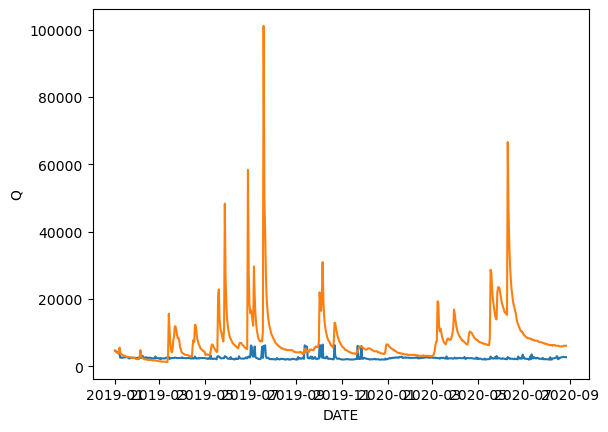

In [84]:
sns.lineplot(pred, x = pred.index, y = 'Q')
sns.lineplot(x = X_test.index, y = y_test)

<Axes: xlabel='DATE', ylabel='h'>

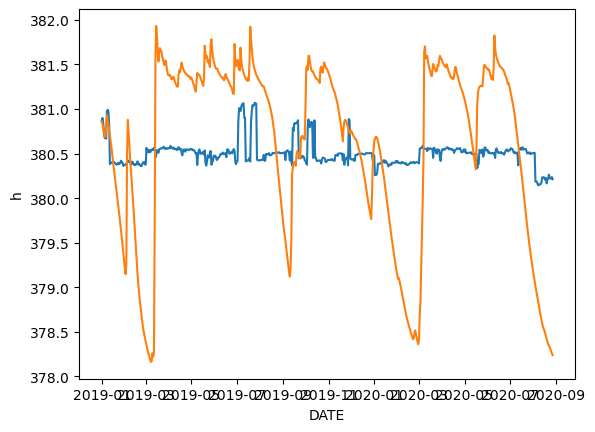

In [86]:
sns.lineplot(pred, x = pred.index, y = 'h')
sns.lineplot(x = X_test.index, y = y_test)

Text(0.5, 1.0, 'Head')

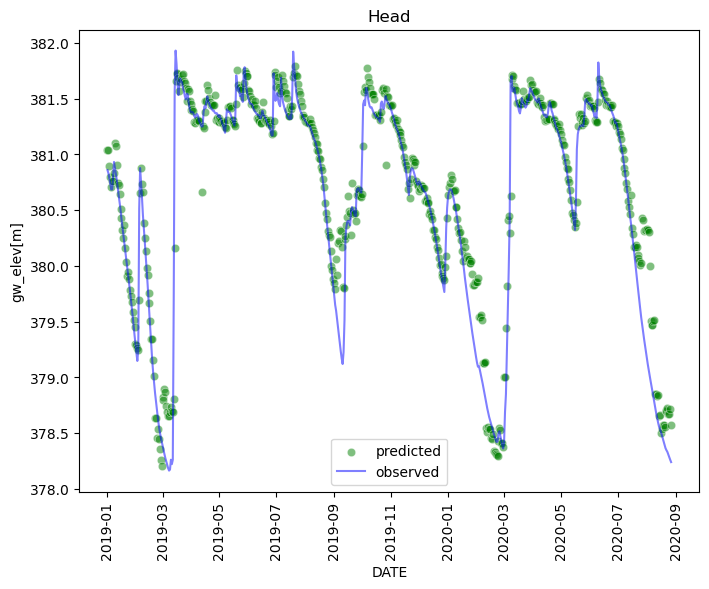

In [80]:
y_pred = model.predict(X_test)
fig, ax = plt.subplots(figsize = (8,6))
sns.scatterplot(x = y_test.index, y = y_pred, label = 'predicted', alpha = 0.5, color = 'green')
sns.lineplot(x = y_test.index, y = y_test, label = 'observed', alpha = 0.5, color = 'blue')
plt.xticks(rotation = 90)
plt.title("Head")


12

Text(0.5, 1.0, 'Feature Importance for h Prediction')

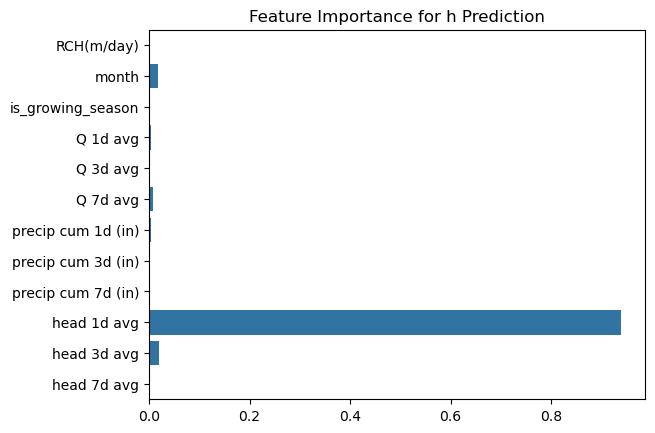

In [81]:
sns.barplot(y = model.feature_names_in_, x = model.feature_importances_)
# plt.xticks(rotation = 90)
plt.title("Feature Importance for h Prediction")